In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats.mstats import mquantiles
from scipy import stats


## a. Dataset
The $load$ list contains the load demand $\mathbf{L}_{T \times S}$ of each state of india $s = 1, \dots, S$ for each hour of a year $t = 1, \dots, T$, where $S$ is the total number of states and $T$ the total number of hours in a year.
The $mapre$ list contains the names potential renewable energy zones: $\mathcal{S}_{names}$ (solar) and $\mathcal{W}^{names}$ (wind); and the potential power capacity $\mathbf{s}_{Cap}$ (solar) and $\mathbf{w}_{Cap}$ (wind). The total number of potential renewable energy zones are $P^{solar}$ for solar and $P^{wind}$ for wind.
The capacity factors of each potential renewable energy zone $P^{solar}$ and $P^{wind}$ are in the list $capacity$. The capacity factors are $\mathbf{C}^{solar}_{P^{solar} \times T \times Y}$ and $\mathbf{C}^{wind}_{P^{wind} \times T \times Y}$, where $y = 1, \dots, Y$ is the index of the year, and $Y$  is the total number of years.

In [2]:
with open('india_power_dataset.pkl', 'rb') as _file:
    load_, mapre_, capacity_ = pickle.load(_file)
L_, time_                          = load_  
s_Cap_, s_names_, w_Cap_, w_names_ = mapre_
S_cf_, W_cf_                       = capacity_
#print( L_.shape , time_.shape)
#print(s_Cap_.shape, s_names_.shape, w_Cap_.shape, w_names_.shape)
print(S_cf_.shape, W_cf_.shape)

# for i in range(18):
#     print(i, np.sum(np.isnan(S_cf_[..., i])), np.sum(np.isnan(W_cf_[..., i])))
    
S_cf_ = np.delete(S_cf_, [0, 4, 8, 12], axis = 2)
W_cf_ = np.delete(W_cf_, [0, 4, 8, 12], axis = 2)
print(S_cf_.shape, W_cf_.shape)

# for i in range(14):
#     print(i, np.sum(np.isnan(S_cf_[..., i])), np.sum(np.isnan(W_cf_[..., i])))


(566, 8760, 18) (311, 8760, 18)
(566, 8760, 14) (311, 8760, 14)


## b. Experiments

### 1. Analysis of the load demand in India: Load variability
#### Methodolly
1. Total energy demand of each state in India: $\mathbf{l}_{T \times 1}$.
2. Total energy demand in India: $L$.
3. Uncertanty analysis:
    * Variability of an State in India.
        - Reshape the data $\mathbf{L}_{T \times S} \rightarrow \mathbf{L}_{D \times H\times S}$, where $D = 365$ is the number of days in a year and $H = 24$ is the number of hours in a day.
        - Aggregate the demand of all states $\mathbf{L}_{D \times H}$.
4. Seasonal uncertanty analysis:
    * Index of the days that belong to each season: $\mathbf{i}^{winter}_{D \times 1}, \mathbf{i}^{spring}_{D \times 1}, \mathbf{i}^{summer}_{D \times 1}$ and $\mathbf{i}^{fall}_{D \times 1}$. If day $d$ is from the sasson then $i_d = True$, otherwise $i_d = False$. True or false in math is just 1 or 0, which is a binary number.
    * Get the load of the days by seasson: $\mathbf{L}^{winter}_{D^{winter} \times H}$, $\mathbf{L}^{spring}_{D^{spring} \times H}$, $\mathbf{L}^{summer}_{D^{summer} \times H}$, and $\mathbf{L}^{fall}_{D^{fall} \times H}$.
5. Compute total energy per day $\mathbf{L}_{D \times 1}$ by aggregating $\mathbf{L}_{D \times H}$.

In [3]:
# 1. 
l_ = np.sum(L_ , axis = 1)[:, np.newaxis] # hourly energy demand in India
print(l_.shape) 

g_ = np.sum(L_, axis = 0) # total energy demand of each state per year
print(g_.shape) 

#2
L = np.sum(l_, axis = 0) # total energy demand of India 
print(L.shape)

#3
L_reshape_ = L_.reshape(365, 24, 23) # L_(Days,Hours,states)
print(L_reshape_.shape)

L_prime_ = np.sum(L_reshape_,axis = 2)
print(L_prime_.shape)

(8760, 1)
(23,)
(1,)
(365, 24, 23)
(365, 24)


In [4]:
#4
idx_days_ = np.arange(365, dtype = int)

spring_begin = 79
spring_end   = 169
idx_spring_  = ((idx_days_ >= spring_begin) & (idx_days_ < spring_end))
print(idx_spring_.sum())

summer_begin = 169
summer_end   = 261
idx_summer_  = ((idx_days_ >= summer_begin) & (idx_days_ < summer_end))
print(idx_summer_.sum())

fall_begin = 261
fall_end   = 352
idx_fall_  = ((idx_days_ >= fall_begin) & (idx_days_ < fall_end))
print(idx_fall_.sum())

winter_begin = 0
winter_end   = 79
winter_Begin = 352
winter_End   = 365
idx_winter_  = (((idx_days_ >= winter_begin) & (idx_days_ < winter_end)) | ((idx_days_ >= winter_Begin) & (idx_days_ <= winter_End)))
print(idx_winter_.shape, idx_winter_.sum())

L_winter_ = L_prime_[idx_winter_, :]
print(L_prime_.shape, L_winter_.shape)

L_spring_ = L_prime_[idx_spring_, :] 

L_summer_ = L_prime_[idx_summer_, :]

L_fall_ = L_prime_[idx_fall_, :]

90
92
91
(365,) 92
(365, 24) (92, 24)


In [6]:
#5 
L_day = np.sum( L_prime_, axis= 1)[:,np.newaxis]
print(L_day.shape) 

(365, 1)


#### Visualization
1. Compute the total energy demand of india per day $\bar{\mathbf{l}}_{D \times 1}$ (from before)
2. Compute the total scaled energy generated by solar and wind resources for multiple years:
    * $\mathbf{E}^{solar}_{P^{solar} \times T \times Y} = \alpha^{solar} \mathbf{s}_{cap} \odot \mathbf{C}^{solar}_{P^{solar} \times T \times Y}$ and $\mathbf{E}^{wind}_{P^{wind} \times T \times Y} = \alpha^{wind} \mathbf{w}_{cap} \odot \mathbf{C}^{wind}_{P^{wind} \times T \times Y}$
    * Aggregate accros potential renewable energy zones: $\mathbf{E}^{solar}_{T \times Y}$ and $\mathbf{E}^{wind}_{T \times Y}$
    * Reshape $\mathbf{E}^{solar}_{T \times Y}$ and $\mathbf{E}^{wind}_{T \times Y}$ to get year day and hours: $\mathbf{E}^{solar}_{D \times H \times Y}$ and $\mathbf{E}^{wind}_{D \times H \times Y}$
    * Aggregate $\mathbf{E}^{solar}_{D \times H \times Y}$ and $\mathbf{E}^{wind}_{D \times H \times Y}$ across hours: $\mathbf{E}^{solar}_{D \times Y}$ and $\mathbf{E}^{wind}_{D \times Y}$
3. Compute statistics of $\mathbf{E}^{solar}_{D \times Y}$ and $\mathbf{E}^{wind}_{D \times Y}$: median $\mathbf{m}_{D \times 1}$, and quantile at 0, 25, 75, and 100: $\mathbf{q}^{0}_{D \times 1}, \mathbf{q}^{25}_{D \times 1}, \mathbf{q}^{75}_{D \times 1}$ and $\mathbf{q}^{100}_{D \times 1}$.
4. Plot $\bar{\mathbf{l}}_{D \times 1}$, $\mathbf{m}^{solar}_{D \times 1}$ and $\mathbf{m}^{wind}_{D \times 1}$ and add shades to the graph within the quantiles.

In [5]:
def _daily_stats(Data_):  
    # Median
    med_      = np.mean(Data_, axis = 0)
    # Quantile Statistics
    quantiles = stats.mstats.mquantiles(Data_, [0.025, 0.2, 0.8, .975], axis = 0)
    q_0_      = quantiles[0, :]
    q_25_     = quantiles[1, :]
    q_75_     = quantiles[2, :]
    q_100_    = quantiles[3, :]
    return med_[:, np.newaxis], q_0_[:, np.newaxis], q_25_[:, np.newaxis], q_75_[:, np.newaxis], q_100_[:, np.newaxis]

In [6]:
#1 
l_w_med_, l_w_q_0_, l_w_q_25_, l_w_q_75_, l_w_q_100_            = _daily_stats(L_winter_)
l_spr_med_, l_spr_q_0_ , l_spr_q_25_, l_spr_q_75_, l_spr_q_100_ = _daily_stats(L_spring_)
l_smr_med_, l_smr_q_0_ , l_smr_q_25_, l_smr_q_75_, l_smr_q_100_ = _daily_stats(L_summer_)
l_f_med_, l_f_q_0_ , l_f_q_25_, l_f_q_75_, l_f_q_100_           = _daily_stats(L_fall_)

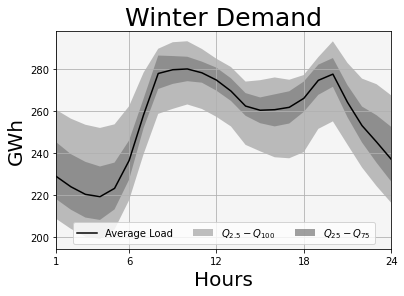

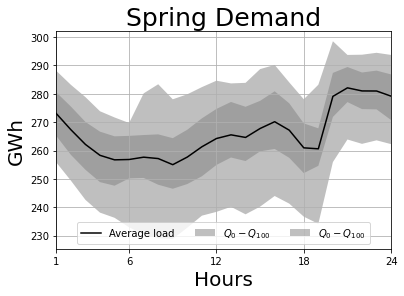

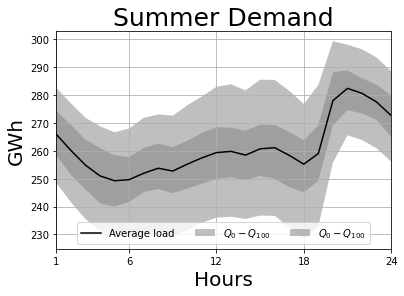

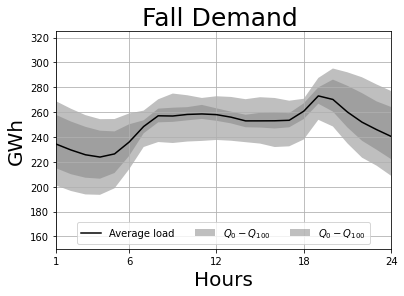

In [8]:
#winter
x_ = np.arange(l_w_med_.shape[0], dtype = int)

plt.figure()
plt.gca().set_facecolor('whitesmoke')

plt.grid()
plt.title('Winter Demand', fontsize = 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel('GWh',   fontsize = 20)
plt.plot(x_, l_w_med_/1000.,'k', label = 'Average Load')
plt.fill_between(x_, l_w_q_0_[:, 0]/1000., l_w_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, l_w_q_25_[:, 0]/1000., l_w_q_75_[:, 0]/1000., alpha = 0.75, edgecolor = 'none', facecolor = 'gray', label = '$Q_{25}-Q_{75}$')


#plt.ylim([150, 325])
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
plt.legend(fontsize = 10., loc = 'lower center', ncol = 3)


plt.show()

#spring
plt.figure()
plt.grid()

plt.title('Spring Demand', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel('GWh', fontsize = 20 )
plt.plot(x_, l_spr_med_/1000, 'k', label = 'Average load')
plt.fill_between(x_, l_spr_q_0_[:, 0]/1000., l_spr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_spr_q_25_[:, 0]/1000., l_spr_q_75_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

#plt.ylim([150, 325])
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
plt.legend(fontsize = 10., loc = 'lower center', ncol = 3)
plt.show()

#summer
plt.figure()
plt.grid()

plt.title('Summer Demand', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel('GWh', fontsize = 20 )
plt.plot(x_,l_smr_med_/1000, 'k', label = 'Average load')
plt.fill_between(x_, l_smr_q_0_[:, 0]/1000., l_smr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_smr_q_25_[:, 0]/1000., l_smr_q_75_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

#plt.ylim([150, 325])
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
plt.legend(fontsize = 10., loc = 'lower center', ncol = 3)
plt.show()

#fall
plt.figure()
plt.grid()

plt.title('Fall Demand ', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel('GWh', fontsize = 20 )
plt.plot(x_,l_f_med_/1000, 'k', label = 'Average load')
plt.fill_between(x_, l_f_q_0_[:, 0]/1000., l_f_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_f_q_25_[:, 0]/1000., l_f_q_75_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.ylim([150, 325])
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
plt.legend(fontsize = 10., loc = 'lower center', ncol = 3)
plt.show()

### 2. Potential renewable energy capacity in India.
1. Compute the total potential energy generated in each renewable energy zone for a year, for instance $y = 2$, so we have $\mathbf{E}^{solar}_{P^{solar} \times T} = \mathbf{s}^{cap} \odot \mathbf{C}^{solar}_{P^{solar} \times T}$ and $\mathbf{E}^{wind}_{P^{wind} \times T} = \mathbf{w}^{cap} \odot \mathbf{C}^{wind}_{P^{wind} \times T}$
2. Aggregate the energy across all projects so we have $\mathbf{e}^{solar}_{T \times 1}$ and $\mathbf{e}^{wind}_{T \times 1}$.
2. Compute the total potential energy that India can generate from solar and wind resource, so we have $E^{solar}$ and $E^{wind}$

[[0.72303273]
 [0.54554271]
 [0.50555667]
 [0.71154714]
 [0.5158644 ]
 [0.46948369]
 [0.67136518]
 [0.55149662]
 [0.43827768]
 [0.69708191]
 [0.56385365]
 [0.73475918]
 [0.52246839]
 [0.45236499]]
[[0.28271844]
 [0.28065193]
 [0.28468978]
 [0.2829538 ]
 [0.28280378]
 [0.28177972]
 [0.28128871]
 [0.28731054]
 [0.28104448]
 [0.28607884]
 [0.28437216]
 [0.28899252]
 [0.29622891]
 [0.3019249 ]]
0.14295851840237575
0.2893819616312035


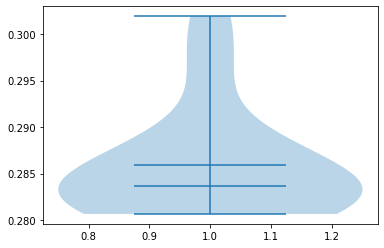

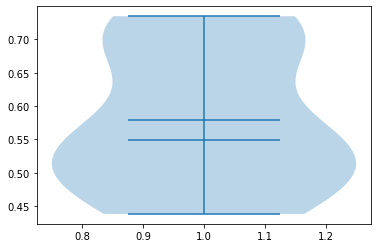

In [15]:
# Compute the average of system scale
def _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB):
    r_w = 1 - r_s
    #1
    s_Cap_prime_ = np.repeat(s_Cap_[..., np.newaxis], 8760, axis = 1)
    s_Cap_prime_ = np.repeat(s_Cap_prime_[..., np.newaxis], 14, axis = 2)
    w_Cap_prime_ = np.repeat(w_Cap_[..., np.newaxis], 8760, axis = 1)
    w_Cap_prime_ = np.repeat(w_Cap_prime_[..., np.newaxis], 14, axis = 2)

    E_s_pot_year_ = s_Cap_prime_ * S_cf_
    E_w_pot_year_ = w_Cap_prime_ * W_cf_
    #2
    e_s_tot_years_ = np.sum(np.sum(E_s_pot_year_, axis = 0), axis = 0)[:, np.newaxis]
    e_w_tot_years_ = np.sum(np.sum(E_w_pot_year_, axis = 0), axis = 0)[:, np.newaxis]
    #3 
    beta_s_ = L/e_s_tot_years_
    beta_hat_s = np.mean(beta_s_) 
    beta_w_ = L/e_w_tot_years_
    beta_hat_w = np.mean(beta_w_) 
    
    #4 solar 
    a_s_avg = r_s * beta_hat_s * OB
    a_w_avg = r_w * beta_hat_w * OB

    return a_s_avg , a_w_avg, beta_s_, beta_w_


r_s = .5
r_w = 1 - r_s
OB  = 1 

a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)
print(beta_w_)
print(beta_s_)

print(a_hat_s)
print(a_hat_w)
  
plt.figure()
plt.violinplot(beta_s_, showmeans = True, showextrema = True, showmedians = True)
plt.show()

plt.figure()
plt.violinplot(beta_w_, showmeans = True, showextrema = True, showmedians = True)
plt.show()

In [16]:
###  1 solar 
y = 1
S_cf_prime_ = S_cf_[:, :, y] # takes information from one year 
S_Cap_      = s_Cap_[:, np.newaxis] # creates new axis 
S_Cap_      = np.repeat(S_Cap_, S_cf_prime_.shape[1], axis = 1) # repeats integers in axis= 1 to fill desired shape 
#print(S_Cap_.shape, S_cf_prime_.shape) 

E_solar_ = S_Cap_ * S_cf_prime_  # each zone energy generation per hour 
#2 solar 
e_solar_ = np.sum(E_solar_, axis = 0)[:, np.newaxis] # total solar energy generation per hour
#3 solar 
E_solar  = np.sum(e_solar_, axis = 0) # total energy solar generation 
print(E_solar_.shape, e_solar_.shape, E_solar) 

(566, 8760) (8760, 1) [8.05258668e+09]


In [17]:
###  1 wind 
W_cf_prime_ = W_cf_[:, :, y] # takes data for 1 year 
W_Cap_ = w_Cap_[:, np.newaxis] #creates new axis 
W_Cap_ = np.repeat(W_Cap_, W_cf_prime_.shape[1], axis = 1) # repeats integers in axis= 1 to fill desired shape 
E_wind_ = W_cf_prime_ * W_Cap_

#2 wind
e_wind_ = np.sum(E_wind_, axis = 0)[:,np.newaxis]# wind energy generation per zone for one year 

#3 wind
E_wind = np.sum(e_wind_,axis = 0)

print(E_wind_.shape, e_wind_.shape,E_wind)


(311, 8760) (8760, 1) [4.14261612e+09]


#### Visualization
1. Reshape $\mathbf{e}^{solar}_{T \times 1}$ and $\mathbf{e}^{wind}_{T \times 1}$ to have year days and hours: $\mathbf{E}^{solar}_{D \times H}$ and $\mathbf{E}^{wind}_{D \times H}$
2. Compute statistics for each season across the days $D^{winter}, D^{spring}, D^{summer}$ and $D^{fall}$: median $\mathbf{m}_{H \times 1}$, and quantile at 0, 25, 75, and 100: $\mathbf{q}^{0}_{H \times 1}, \mathbf{q}^{25}_{H \times 1}, \mathbf{q}^{75}_{H \times 1}$ and $\mathbf{q}^{100}_{H \times 1}$.
3. Repeat previous plot for the solar and wind using different colors. For instance, blue for wind and yellow for solar. Inclide the shades of the quantiles with the shade transparency decreasing as the quantiles increases.

In [18]:
E_solar_prime_ = e_solar_.reshape(365, 24)

#solar 
S_winter_ = E_solar_prime_[idx_winter_, :] 
S_w_med_, S_w_q_0_ , S_w_q_25_, S_w_q_75_, S_w_q_100_           = _daily_stats(a_hat_s*S_winter_)

S_spring_ = E_solar_prime_[idx_spring_, :] 
S_spr_med_, S_spr_q_0_ , S_spr_q_25_, S_spr_q_75_, S_spr_q_100_ = _daily_stats(a_hat_s*S_spring_)

S_summer_ = E_solar_prime_[idx_summer_, :] 
S_smr_med_, S_smr_q_0_ , S_smr_q_25_, S_smr_q_75_, S_smr_q_100_ = _daily_stats(a_hat_s*S_summer_)

S_fall_ = E_solar_prime_[idx_fall_, :] 
S_f_med_, S_f_q_0_ , S_f_q_25_, S_f_q_75_, S_f_q_100_           = _daily_stats(a_hat_s*S_fall_)  

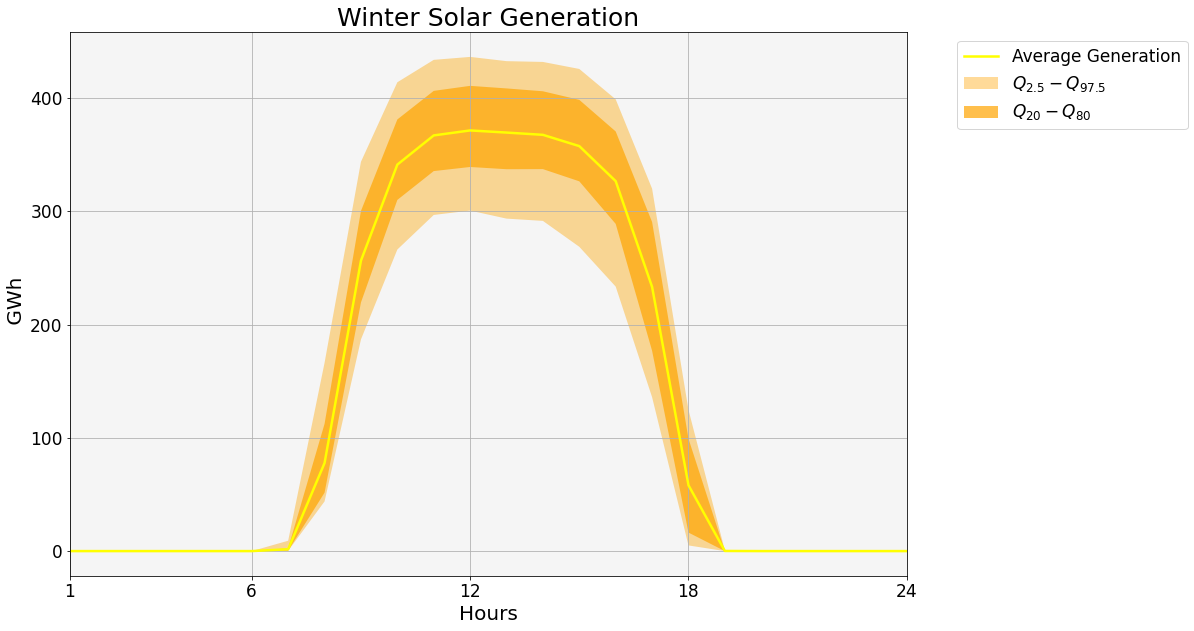

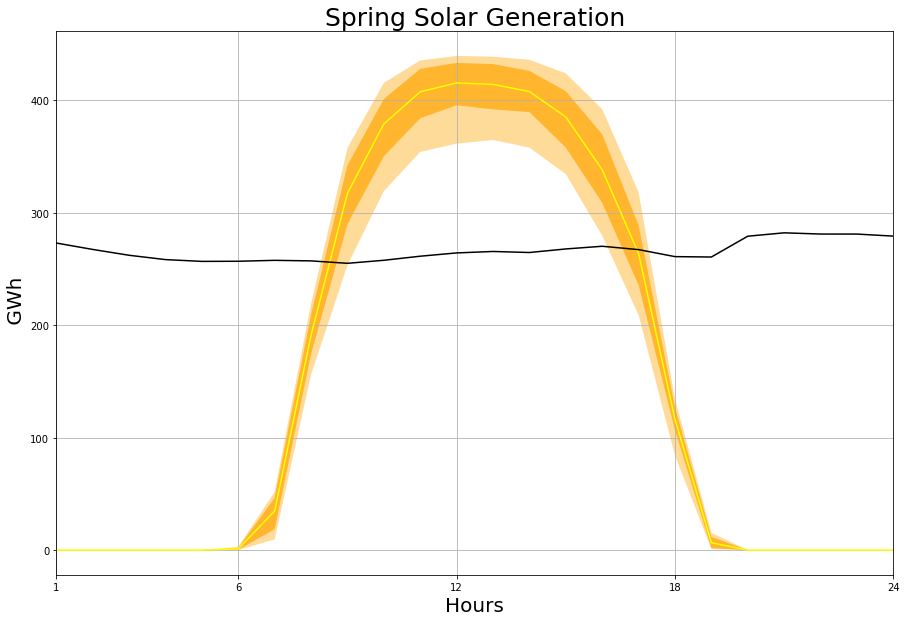

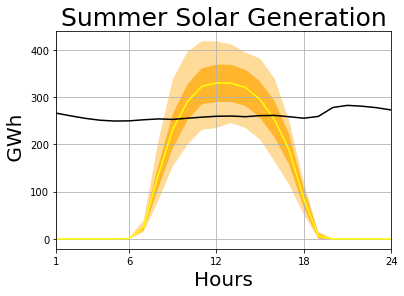

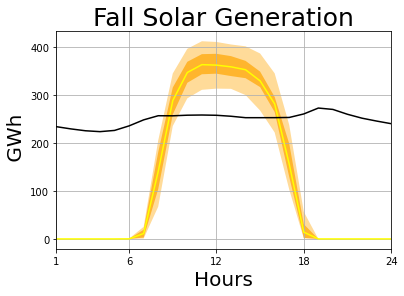

In [19]:
#solar winter
plt.figure(figsize = (15, 10))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_, S_w_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Generation')
plt.fill_between(x_, S_w_q_0_[:, 0]/1000., S_w_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_w_q_25_[:, 0]/1000., S_w_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.title('Winter Solar Generation', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 17.)
plt.yticks(fontsize = 17.)


plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 17.)
plt.grid()
plt.show()

## solar spring
plt.figure(figsize = (15, 10))
plt.grid()

plt.title('Spring Solar Generation', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.plot(x_, S_spr_med_/1000, 'yellow', label = 'Average Generation')
plt.fill_between(x_, S_spr_q_0_[:, 0]/1000., S_spr_q_100_[:, 0]/1000.,  alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_spr_q_25_[:, 0]/1000., S_spr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_spr_med_/1000, 'k', label = 'Average load')


plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
#plt.legend(fontsize = 10., loc = 'lower center')
plt.show()

#solar summer 

## solar spring
plt.figure()
plt.grid()

plt.title('Summer Solar Generation', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.plot(x_, S_smr_med_/1000, 'yellow', label = 'Average Generation')
plt.fill_between(x_, S_smr_q_0_[:, 0]/1000., S_smr_q_100_[:, 0]/1000.,  alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')

plt.fill_between(x_, S_smr_q_25_[:, 0]/1000., S_smr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')


plt.plot(x_, l_smr_med_/1000, 'k', label = 'Average load')


plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
plt.show()

#solar fall
plt.figure()
plt.grid()

plt.title('Fall Solar Generation', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.plot(x_, S_f_med_/1000, 'yellow', label = 'Average Generation')
plt.fill_between(x_, S_f_q_0_[:, 0]/1000., S_f_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')

plt.fill_between(x_, S_f_q_25_[:, 0]/1000., S_f_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_f_med_/1000, 'k', label = 'Average load')



plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
#plt.legend(fontsize = 10., loc = 'lower center')
plt.show()
#
#plt.savefig(path + r'/{}.pdf'.format(/Users/dlopez/Desktop/india_power/Images), dpi = 500)

In [20]:
E_wind_prime_  = e_wind_.reshape(365,24)


W_winter_ = E_wind_prime_[idx_winter_, :] 
W_w_med_, W_w_q_0_ , W_w_q_25_, W_w_q_75_,W_w_q_100_            = _daily_stats(a_hat_w * W_winter_)
W_spring_ = E_wind_prime_[idx_spring_, :] 
W_spr_med_, W_spr_q_0_ , W_spr_q_25_, W_spr_q_75_, W_spr_q_100_ = _daily_stats(a_hat_w * W_spring_)

W_summer_ = E_wind_prime_[idx_summer_, :] 
W_smr_med_, W_smr_q_0_ , W_smr_q_25_, W_smr_q_75_, W_smr_q_100_ = _daily_stats(a_hat_w * W_summer_)

W_fall_ = E_wind_prime_[idx_fall_, :] 
W_f_med_, W_f_q_0_ , W_f_q_25_, W_f_q_75_, W_f_q_100_           = _daily_stats(a_hat_w * W_fall_)  

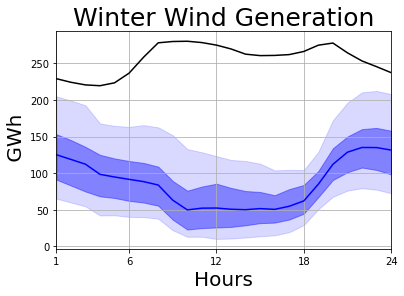

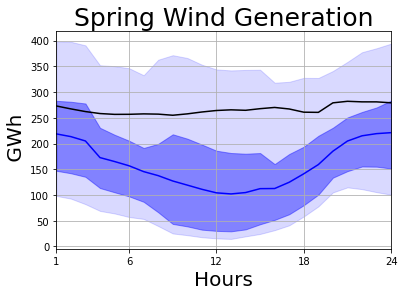

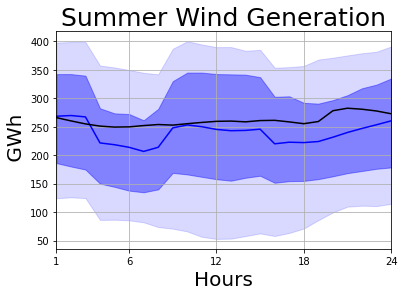

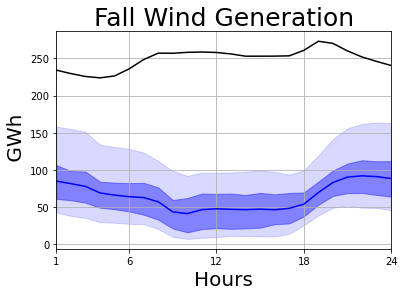

In [21]:
#wind winter
plt.figure()
plt.grid()

plt.title('Winter Wind Generation', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.plot(x_,W_w_med_/1000, 'b', label = 'Average Generation')
plt.fill_between(x_, W_w_q_0_[:, 0]/1000., W_w_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_w_q_25_[:, 0]/1000., W_w_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, l_w_med_/1000, 'k', label = 'Average load')


plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 10.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images'+ '_Wind_winter', dpi='figure', format='pdf')
plt.show()

## wind spring
plt.figure()
plt.grid()

plt.title('Spring Wind Generation', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.plot(x_,W_spr_med_/1000, 'b', label = 'Average Generation')
plt.fill_between(x_, W_spr_q_0_[:, 0]/1000., W_spr_q_100_[:, 0]/1000., alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_spr_q_25_[:, 0]/1000., W_spr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, l_spr_med_/1000, 'k', label = 'Average load')



plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
plt.savefig('/Users/dlopez/Desktop/india_power/Images'+ '_Wind_spring', dpi='figure', format='pdf')


plt.show()

#wind summer
plt.figure()
plt.grid()

plt.title('Summer Wind Generation', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.plot(x_,W_smr_med_/1000, 'b', label = 'Average Generation')
plt.fill_between(x_, W_smr_q_0_[:, 0]/1000., W_smr_q_100_[:, 0]/1000., alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_smr_q_25_[:, 0]/1000., W_smr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, l_smr_med_/1000, 'k', label = 'Average load')

# plt.fill_between(x_, smr_q_0_[:, 0]/1000., smr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'grey', label = '$Q_{0}-Q_{100}$')
# plt.fill_between(x_, smr_q_25_[:, 0]/1000., smr_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'grey', label = '$Q_{0}-Q_{100}$')

plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
plt.savefig('/Users/dlopez/Desktop/india_power/Images'+ '_Wind_summer', dpi='figure', format='pdf')


plt.show()

#wind fall
plt.figure()
plt.grid()

plt.title('Fall Wind Generation', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.plot(x_,W_f_med_/1000, 'b', label = 'Average Generation')
plt.fill_between(x_, W_f_q_0_[:, 0]/1000., W_f_q_100_[:, 0]/1000., alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_f_q_25_[:, 0]/1000., W_f_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, l_f_med_/1000, 'k', label = 'Average load')


plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24])
plt.savefig('/Users/dlopez/Desktop/india_power/Images'+ '_Wind_fall', dpi='figure', format='pdf')


plt.show()


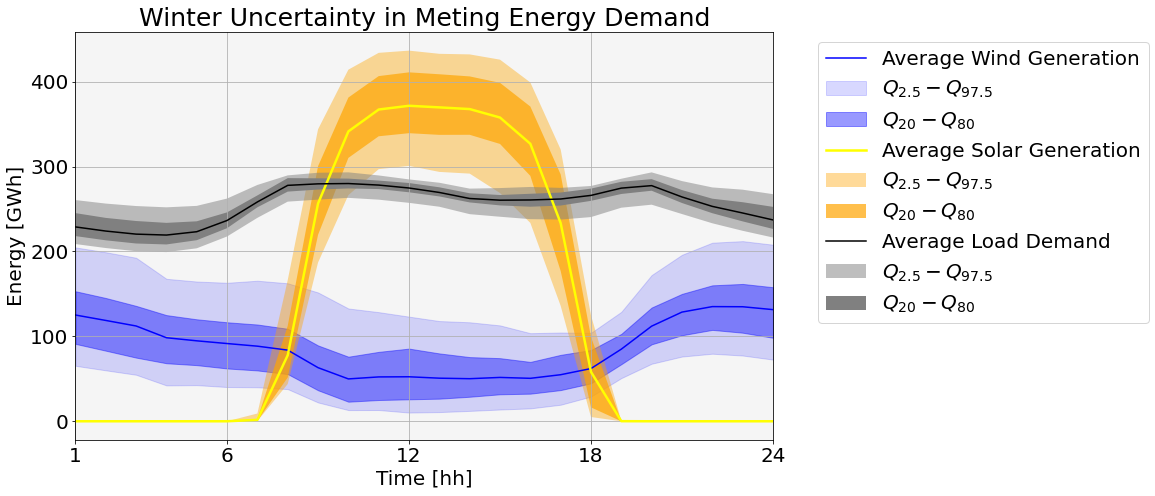

In [22]:
# winter
plt.figure(figsize = (12.5, 7.5))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_w_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_w_q_0_[:, 0]/1000., W_w_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, W_w_q_25_[:, 0]/1000., W_w_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, S_w_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_w_q_0_[:, 0]/1000., S_w_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_w_q_25_[:, 0]/1000., S_w_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_w_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_w_q_0_[:, 0]/1000., l_w_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, l_w_q_25_[:, 0]/1000., l_w_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{20}-Q_{80}$')

plt.title('Winter', fontsize= 25)
plt.xlabel('Time [hh]', fontsize = 20)
plt.ylabel('Energy [GWh]', fontsize = 20 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 20)
plt.yticks(fontsize = 20.)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc ='upper left' ,fontsize = 20.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images/' + '_winter.png',dpi='figure',bbox_inches='tight')


plt.grid()
plt.show()

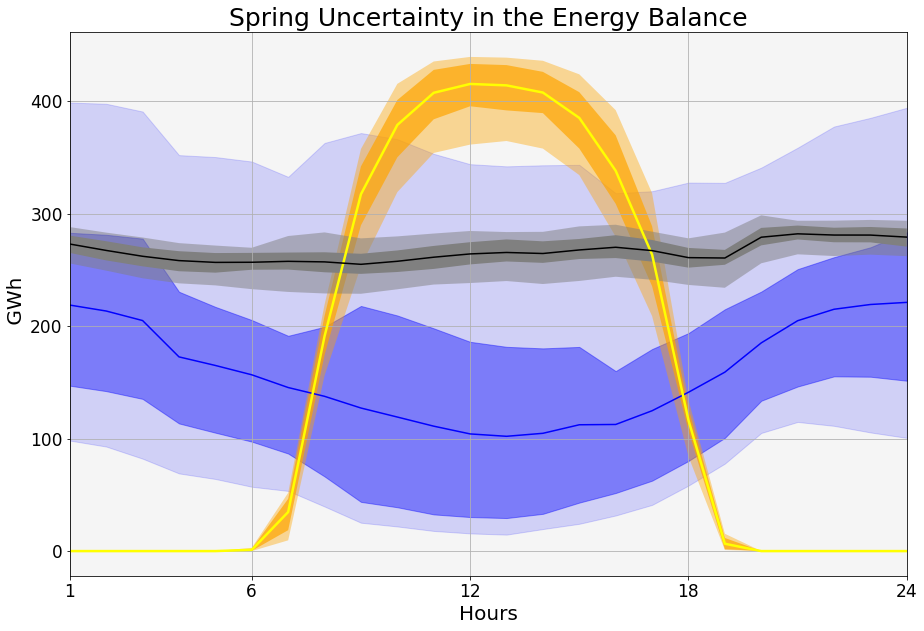

In [23]:
# spring
plt.figure(figsize = (15, 10))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_spr_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_spr_q_0_[:, 0]/1000., W_spr_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_spr_q_25_[:, 0]/1000., W_spr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, S_spr_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_spr_q_0_[:, 0]/1000., S_spr_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_spr_q_25_[:, 0]/1000., S_spr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_spr_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_spr_q_0_[:, 0]/1000., l_spr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, l_spr_q_25_[:, 0]/1000., l_spr_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Spring Uncertainty in the Energy Balance', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 17.)
plt.yticks(fontsize = 17.)

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 17.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images'+ '_Spring', dpi = 200, format = 'pdf')

plt.grid()
plt.show()

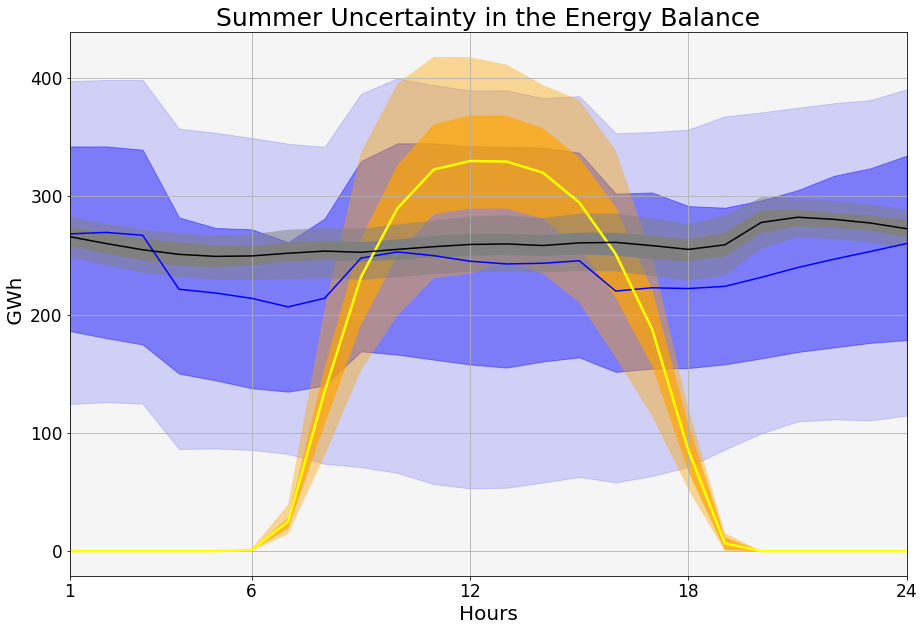

In [24]:
# wsummer
plt.figure(figsize = (15, 10))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_smr_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_smr_q_0_[:, 0]/1000., W_smr_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_smr_q_25_[:, 0]/1000., W_smr_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, S_smr_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_smr_q_0_[:, 0]/1000., S_smr_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_smr_q_25_[:, 0]/1000., S_smr_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_smr_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_smr_q_0_[:, 0]/1000., l_smr_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_smr_q_25_[:, 0]/1000., l_smr_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Summer Uncertainty in the Energy Balance', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 17.)
plt.yticks(fontsize = 17.)

#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 17.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images'+ '_Summer', dpi='figure', format='pdf')

plt.grid()
plt.show()

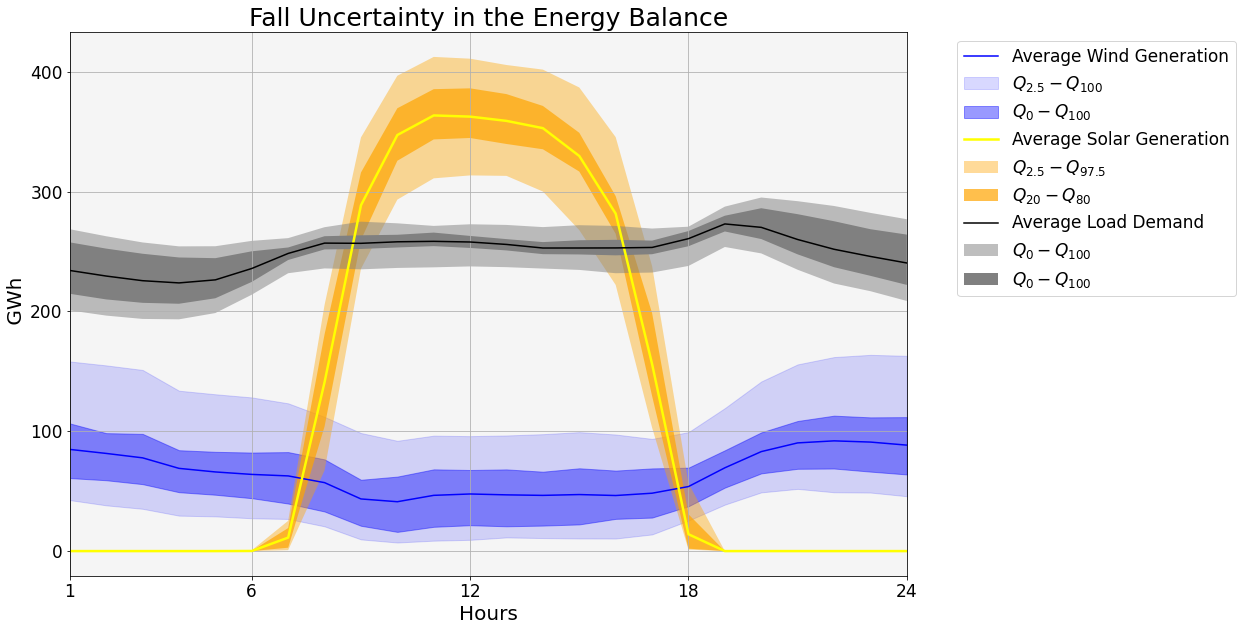

In [20]:
# winter
plt.figure(figsize = (15, 10))
plt.gca().set_facecolor('whitesmoke')

plt.plot(x_,W_f_med_/1000, 'b', label = 'Average Wind Generation')
plt.fill_between(x_, W_f_q_0_[:, 0]/1000., W_f_q_100_[:, 0]/1000.,alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(x_, W_f_q_25_[:, 0]/1000., W_f_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{0}-Q_{100}$')

plt.plot(x_, S_f_med_/1000, color = 'yellow', linewidth = 2.5, label = 'Average Solar Generation')
plt.fill_between(x_, S_f_q_0_[:, 0]/1000., S_f_q_100_[:, 0]/1000., alpha = 0.4,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{2.5}-Q_{97.5}$')
plt.fill_between(x_, S_f_q_25_[:, 0]/1000., S_f_q_75_[:, 0]/1000., alpha = .7,  edgecolor = 'none', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.plot(x_, l_f_med_/1000, 'k', label = 'Average Load Demand')
plt.fill_between(x_, l_f_q_0_[:, 0]/1000., l_f_q_100_[:, 0]/1000., alpha = 0.5,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')
plt.fill_between(x_, l_f_q_25_[:, 0]/1000., l_f_q_75_[:, 0]/1000., alpha = 1.,  edgecolor = 'none', facecolor = 'gray', label = '$Q_{0}-Q_{100}$')

plt.title('Fall Uncertainty in the Energy Balance', fontsize= 25)
plt.xlabel('Hours', fontsize = 20)
plt.ylabel(' GWh', fontsize = 20 )
plt.xlim([0, 23])
plt.xticks([0, 5, 11, 17, 23], [1, 6, 12, 18, 24], fontsize = 17.)
plt.yticks(fontsize = 17.)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 17.)
plt.savefig('/Users/dlopez/Desktop/india_power/Images'+ '_Fall', dpi='figure', format='pdf')

plt.grid()
plt.show()

### 3. Fraction of solar and wind energy to blance the demand.

#### Methods

1. Compute the fraction of the total energy generate from solar necessary to balance the load demand: $\beta^{solar}= \frac{L}{E^{solar}}$.
2. Similarly, fraction of the total energy generate from wind to balance the load demand: $\beta^{wind}= \frac{L}{E^{wind}}$.
3. Compute the franction of the load we want to meet with each source:
    * Define the fraction of solar $\rho_{solar}$, and calculate the one of wind $\rho_{wind} = ( 1 - \rho_{solar})$.
    * Scale the solar generation $\alpha^{solar} = \rho^{solar} \cdot \beta^{solar}\cdot O$, and wind generation $\alpha^{wind} = \rho^{wind} \cdot \beta^{wind} \cdot O$, and define oversizing if it is, otherwise $O = 1$.
    

In [21]:
## 3
r_solar = .5
r_wind  = 1. - r_solar
OB      = 1

a_s_avg, a_w_avg ,x ,y = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L,r_solar,OB)


print(a_solar)
print(a_wind)

NameError: name 'a_solar' is not defined

#### Visualization
1. Compute the total energy demand of india per day $\bar{\mathbf{l}}_{D \times 1}$ (from before)
2. Compute the total scaled energy generated by solar and wind resources for multiple years:
    * $\mathbf{E}^{solar}_{P^{solar} \times T \times Y} = \alpha^{solar} \mathbf{s}_{cap} \odot \mathbf{C}^{solar}_{P^{solar} \times T \times Y}$ and $\mathbf{E}^{wind}_{P^{wind} \times T \times Y} = \alpha^{wind} \mathbf{w}_{cap} \odot \mathbf{C}^{wind}_{P^{wind} \times T \times Y}$
    * Aggregate accros potential renewable energy zones: $\mathbf{E}^{solar}_{T \times Y}$ and $\mathbf{E}^{wind}_{T \times Y}$
    * Reshape $\mathbf{E}^{solar}_{T \times Y}$ and $\mathbf{E}^{wind}_{T \times Y}$ to get year day and hours: $\mathbf{E}^{solar}_{D \times H \times Y}$ and $\mathbf{E}^{wind}_{D \times H \times Y}$
    * Aggregate $\mathbf{E}^{solar}_{D \times H \times Y}$ and $\mathbf{E}^{wind}_{D \times H \times Y}$ across hours: $\mathbf{E}^{solar}_{D \times Y}$ and $\mathbf{E}^{wind}_{D \times Y}$
3. Compute statistics of $\mathbf{E}^{solar}_{D \times Y}$ and $\mathbf{E}^{wind}_{D \times Y}$: median $\mathbf{m}_{D \times 1}$, and quantile at 0, 25, 75, and 100: $\mathbf{q}^{0}_{D \times 1}, \mathbf{q}^{25}_{D \times 1}, \mathbf{q}^{75}_{D \times 1}$ and $\mathbf{q}^{100}_{D \times 1}$.
4. Plot $\bar{\mathbf{l}}_{D \times 1}$, $\mathbf{m}^{solar}_{D \times 1}$ and $\mathbf{m}^{wind}_{D \times 1}$ and add shades to the graph within the quantiles.


In [ ]:
def year_stats(Data_):  
    # Median
    med_      = np.mean(Data_, axis = 1)
    # Quantile Statistics
    quantiles = stats.mstats.mquantiles(Data_, [0., 0.25, 0.75, 1.], axis = 1)
    q_0_      = quantiles[:,0]
    q_25_     = quantiles[:,1]
    q_75_     = quantiles[:,2]
    q_100_    = quantiles[:,3]
    return med_[:, np.newaxis], q_0_[:, np.newaxis], q_25_[:, np.newaxis], q_75_[:, np.newaxis], q_100_[:, np.newaxis]

In [ ]:
#1
L_day = np.sum( L_prime_, axis= 1)[:,np.newaxis]
print(L_day.shape)

#2
E_S_scaled_a_ =  a_s_avg * S_Cap_[:,:,np.newaxis] * S_cf_
E_S_tot_a_ = np.sum(E_S_scaled_a_, axis= 0)
print(E_S_tot_a_.shape)
E_S_reshape_a_ = E_S_tot_a_.reshape(365,24,14)
print(E_S_reshape_a_.shape)
E_S_days_a_ = np.sum(E_S_reshape_a_,axis=1)
print(E_S_days_a_.shape)

E_w_scaled_a_ =  a_w_avg * W_Cap_[:,:,np.newaxis] * W_cf_
E_w_tot_a_ = np.sum(E_w_scaled_a_, axis= 0)
E_w_reshape_a_ = E_w_tot_a_.reshape(365,24,14)
E_w_days_a_ = np.sum(E_w_reshape_a_,axis=1)



#3
year_ = np.array([0,31,60,91,122,152,182,213,244,274,304,334])
months_ = np.array(['Jan.','Feb.','Mar.','Apr.','May','June','July', 'Aug.','Sep.','Oct.','Nov.','Dec.'])
S_med_a_, S_q_0_a_ , S_q_25_a_, S_q_75_a_, S_q_100_a_  = year_stats(E_S_days_a_)
W_med_a_, W_q_0_a_ , W_q_25_a_, W_q_75_a_, W_q_100_a_  = year_stats(E_w_days_a_)


plt.figure(figsize = (20, 5))
plt.grid()
plt.gca().set_facecolor('whitesmoke')

plt.title('Yearly Energy Demand and Generation',fontsize = 20)
plt.xlabel('Time [Days]', fontsize = 20)
plt.ylabel(' GigaWatts Hour [GWH]', fontsize = 20 )

plt.plot(y_, L_day/1000, 'k', label = 'Daily Load Demand')

plt.plot(y_,W_med_/1000, 'b', label = 'Daily Wind Generation')
plt.fill_between(y_, W_q_0_[:, 0]/1000., W_q_100_[:, 0]/1000., alpha = 0.15,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(y_, W_q_25_[:, 0]/1000., W_q_75_[:, 0]/1000., alpha = 0.4,  edgecolor = 'blue', facecolor = 'blue', label = '$Q_{20}-Q_{80}$')

plt.plot(y_, S_med_a_/1000, 'yellow', label = 'Daily Solar Generation')
plt.fill_between(y_, S_q_0_a_[:, 0]/1000., S_q_100_a_[:, 0]/1000., alpha = .25,  edgecolor = 'orange', facecolor = 'orange', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(y_, S_q_25_a_[:, 0]/1000., S_q_75_a_[:, 0]/1000., alpha = 0.75,  edgecolor = 'orange', facecolor = 'orange', label = '$Q_{20}-Q_{80}$')

plt.xticks(year_,months_,fontsize = 15.)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' ,fontsize = 20.)
plt.yticks(fontsize=15.)
plt.xlim([0, 364])

####  3.1 Average fraction
1. Compute the total potential energy generated in each renewable energy zone for all year in the dataset, $\mathbf{C}^{solar}_{P^{solar} \times T \times Y}$ and $\mathbf{C}^{wind}_{P^{wind} \times T \times Y}$, so that $\mathbf{E}^{solar}_{P^{solar} \times T \times Y} = \mathbf{s}_{cap} \odot \mathbf{C}^{solar}$ and $\mathbf{E}^{wind}_{P^{wind} \times T \times Y} = \mathbf{w}_{cap} \odot \mathbf{C}^{wind}$
2. Compute the total potential energy that India can generate from solar and wind resource, as before, but now we have $E^{solar}_{Y \times 1}$ and $E^{wind}_{Y \times 1}$.
3. Compute the average fraction $\hat{\beta}^{solar} = \frac{1}{Y} \sum_{y = 1}^Y \beta^{solar}_y$ and $\hat{\beta}^{wind} = \frac{1}{Y} \sum_{y = 1}^Y \beta^{wind}_y$, where $Y$ is the total number of years, and $y$ is the index of a year, where $\beta^{solar}_y$ and $\beta^{wind}_y$ are respectively $\beta^{solar}_y = \frac{L}{E^{solar}_y}$ and $\beta^{wind}_y = \frac{L}{E^{wind}_y}$.
4. Compute the average scale of the solar generation $\hat{\alpha}^{solar} = \rho^{solar} \cdot \hat{\beta}^{solar}\cdot OB$, and wind generation $\hat{\alpha}^{wind} = \rho^{wind} \cdot \hat{\beta}^{wind} \cdot OB$, and define oversizing if it is, otherwise $OB = 1$. We can use this factor instead of $\alpha^{solar}$ and $\alpha^{wind}$ from now on.

In [ ]:
E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
E_s_hour_   = np.sum(E_s_scaled_, axis= 0)

E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis]  * W_cf_
E_w_hour_   = np.sum(E_w_scaled_, axis= 0)

E_net_ = (E_s_hour_ + E_w_hour_) - l_

E_net_daily_ = np.sum(np.reshape(E_net_,(365,24,14)), axis=1)
L_net_daily_ = np.sum(np.reshape(l_,(365,24,1)), axis=1)

R_ = 100 * (E_net_daily_ / L_net_daily_)

### 4. Hourly Energy Balance Between Load and Energy Generation
1. Get hourly energy demand aggregate across States: $\mathbf{l}_{T \times 1}$ (from experiment 1).
2. Get hourly solar energy generation aggregate across potential renewable energy zones: $\alpha^{solar} \cdot \mathbf{e}^{solar}_{T \times 1}$.
3. Get hourly solar energy generation aggregate across potential renewable energy zones: $\alpha^{wind} \cdot \mathbf{e}^{wind}_{T \times 1}$.

4. Find the numeber of hours that the balance is not achived $\mathbf{l}_{T \times 1}$ < $\alpha^{solar} \cdot \mathbf{e}^{solar}_{T \times 1}$ + $\alpha^{wind} \cdot \mathbf{e}^{wind}_{T \times 1}$. (edited) 

In [124]:
##1
print(l_.shape)

(8760, 1)


In [125]:
##2 
e_solar_gen_ = a_solar * e_solar_
print(e_solar_gen_.shape)

##3
e_wind_gen_ = a_wind * e_wind_
print(e_wind_gen_.shape)

(8760, 1)
(8760, 1)


In [126]:
##4
met_ = np.less(l_ , e_solar_gen_ + e_wind_gen_)
print(met_.sum())
unmet_ = np.greater(l_ , e_solar_gen_ + e_wind_gen_)
print(unmet_.sum())
     
print(met_.sum()/(unmet_.sum() + met_.sum()))

# unmet_demand = np.count_nonzero(compare_) 
# print(unmet_demand)

4125
4635
0.4708904109589041


### 5. Quantile Statstisics
1. Solar <br>
   a. Median <br>
   b.  Quantative values at .25, .50, .75, 1 <br>
2. Wind <br>
   a. Median <br>
   b.  Quantative values at .25, .50, .75, 1 <br>

In [127]:
#1.a
s_median = np.median(e_solar_gen_, axis=0)
print(s_median)

#1.c
s_quantiles_ = stats.mstats.mquantiles(e_solar_gen_,[0.25, .50 ,0.75, 1.], axis=0)
print(s_quantiles_)


[2860.0900251]
[[     0.        ]
 [  2860.0900251 ]
 [304955.53640547]
 [441943.09606021]]


In [128]:
#2.a
w_median = np.median(e_wind_gen_, axis=0)
print(w_median[0])

#2.b
w_quantiles_ = stats.mstats.mquantiles(e_wind_gen_, prob = [0.25,.50, 0.75, 1.], axis = 0)
print(w_quantiles_)

106959.17374626288
[[ 62000.02023159]
 [106959.17374626]
 [195639.04586289]
 [427176.3949689 ]]


# 6 Analysis of Resililiece
1. Get $\alpha^{solar} , \alpha^{wind}, \mathbf{e}^{solar}_{T \times Y}, \mathbf{e}^{wind}_{T \times Y}$
2. Find $\mathbf{E}^{net}_{T \times Y}$
3. Finding percentage of met and unmet demand 


In [131]:


print(S_Cap_.shape)
#1
r_s = .75
r_w = 1 - r_s
OB  = 1 
a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)

E_s_scaled_ = a_hat_s * S_Cap_[:,:,np.newaxis] * S_cf_

E_s_hour_ = np.sum(E_s_scaled_, axis= 0)
print(E_s_hour_.shape)

E_w_scaled_ = a_hat_w * W_Cap_[:,:,np.newaxis] * W_cf_

E_w_hour_ = np.sum(E_w_scaled_, axis= 0)
print(E_w_hour_.shape)



(566, 8760)
(8760, 14)
(8760, 14)


In [132]:
#2
E_net_ = (E_s_hour_ + E_w_hour_)- l_
print(E_net_.shape)


(8760, 14)


In [1]:
#3
E_net_daily_ = np.sum(np.reshape(E_net_,(365,24,14)), axis=1)
print(E_net_daily_.shape)

L_net_daily_ = np.sum(np.reshape(l_,(365,24,1)), axis=1)
print(L_net_daily_.shape)

N_per_ = 100 * (E_net_daily_ / L_net_daily_) + 100.

plt.figure(figsize = (20, 5))
plt.title('Wind and Solar Resiliance',fontsize = 30, loc = 'left')
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_solar) + ' | Wind Fraction= '+  "{:.2f}".format(r_wind) + ' | Overbuild=' +  "{:.2f}".format(OB), ha = 'left', va = 'top',fontsize=15.)

plt.xlabel('Time [Days]', fontsize = 20)
plt.ylabel('Years', fontsize = 20 )

plt.imshow(N_per_.T, aspect = 'auto', interpolation = 'none', vmin = 0, vmax = 200, cmap = 'inferno')

plt.xticks(year_,months_, fontsize=15)
plt.yticks(np.arange(0,14,1),np.arange(2004,2018,1), fontsize=15)
plt.xlim([0, 364])

cbar = plt.colorbar()
cbar.set_ticklabels(cbar.get_ticks(), fontsize=15)
cbar.set_label(label ='Load Demand Met [%]', fontsize=20)
plt.grid()
plt.show()


plt.savefig('/Users/dlopez/Desktop/india_power/Images'+  "_{:.2f}".format(r_solar) + '_'+ "{:.2f}".format(r_wind)+'_'+ "{:.2f}".format(OB), dpi='figure', format='pdf')


# plt.figure(figsize = (20, 5))
# plt.imshow(N_per_.T, aspect = 'auto', interpolation = 'none', vmin = 0, vmax = 100, cmap = 'inferno')
# plt.colorbar()
# plt.ylim()
# plt.show()

NameError: name 'np' is not defined

# Ramp rates 
1. Finding ramp rate $\mathbf{R}^{solar}_{1+t}, \mathbf{R}^{solar}_{1+t}$
2. Get $\mathbf{R}_{D-1 \times HY}$

In [348]:
##1
dt = 1
print(E_s_hour_.shape, E_w_hour_.shape)

Rr_s_dt1_ =  np.diff(E_s_hour_, n = dt, axis = 0) / dt
print(Rr_s_dt1_.shape)

Rr_w_dt1_ =  np.diff(E_w_hour_, n = dt, axis = 0) / dt
print(Rr_w_dt1_.shape)



(8760, 14) (8760, 14)
(8759, 14)
(8759, 14)


In [527]:
#2
dt = 1

L_net_ = ( E_s_hour_ + E_w_hour_) - l_

Rr_dt1_ = np.diff(L_net_, n = dt, axis = 0)/dt

Rr_dt1_frac_ = (Rr_dt1_ / l_[dt:])*100.


rr_dt1_ = Rr_dt1_frac_[:24 - dt, :]
Rr_dt1_ = Rr_dt1_frac_[24 - dt:, :]
print(rr_dt1_.shape, Rr_dt1_.shape)

rr_dt1_prime_ = rr_dt1_.flatten()[np.newaxis, :]
Rr_dt1_prime_ = np.reshape(Rr_dt1_, (364, 24*14))

# Rr_dt1_prime_ = np.reshape(Rr_dt1_, (24, 364, 14))
# Rr_dt1_prime_ = np.swapaxes(Rr_dt1_prime_, 0, 1)
# Rr_dt1_prime_ = np.reshape(Rr_dt1_prime_, (364, 24*14))
print(rr_dt1_prime_.shape, Rr_dt1_prime_.shape)
# Define Storage Vectors size of year days

idx_ = Rr_dt1_prime_ == 0.
print(idx_.sum())

(23, 14) (8736, 14)
(1, 322) (364, 336)
0


In [528]:
def _hourly_stats(data_):  
    #Quantile Statistics
    m  = np.mean(data_)
    q_ = stats.mstats.mquantiles(data_, [0.025, .2 ,0.8, .975])
    return m, q_

m_pos_ = np.zeros((365, 1))
m_neg_ = np.zeros((365, 1))
Q_pos_ = np.zeros((365, 4))
Q_neg_ = np.zeros((365, 4))

# Compute stats for Janurary 1st positive
idx_ = rr_dt1_prime_[0, :] > 0.

jan_1_med_pos, jan_1_q_pos_ = _hourly_stats(rr_dt1_prime_[0, idx_])
jan_1_med_neg, jan_1_q_neg_ = _hourly_stats(rr_dt1_prime_[0, ~idx_])

# Save Januaray 1st stats in Storage Vectors
m_pos_[0]    = jan_1_med_pos
Q_pos_[0, :] = jan_1_q_pos_
m_neg_[0]    = jan_1_med_neg
Q_neg_[0, :] = jan_1_q_neg_

for i in range(Rr_dt1_prime_.shape[0]):
    idx_pos_ = Rr_dt1_prime_[i, :] > 0.
    
    med_pos, q_pos_ = _hourly_stats(Rr_dt1_prime_[i, idx_pos_])
    med_neg, q_neg_ = _hourly_stats(Rr_dt1_prime_[i, ~idx_pos_])

    m_pos_[i + 1] = med_pos
    m_neg_[i + 1] = med_neg
    Q_pos_[i + 1] = q_pos_
    Q_neg_[i + 1] = q_neg_

(365,) (365, 1) (365, 4) (365, 4)


In [1]:
q_0_pos_      = Q_pos_[:,0]
q_25_pos_     = Q_pos_[:,1]
q_75_pos_     = Q_pos_[:,2]
q_100_pos_    = Q_pos_[:,3]    
q_0_neg_      = Q_neg_[:,0]
q_25_neg_     = Q_neg_[:,1]
q_75_neg_     = Q_neg_[:,2]
q_100_neg_    = Q_neg_[:,3]   
print(q_100_pos_.shape,m_neg_.shape,Q_pos_.shape,Q_neg_.shape)

plt.figure(figsize = (15, 5))
plt.title('Yearly Ramp Rate per Hour',fontsize=30)
plt.suptitle('Solar Fraction = ' +  "{:.2f}".format(r_s) + ' | Wind Fraction= '+  "{:.2f}".format(r_w) + ' | Overbuild=' +  "{:.2f}".format(OB), ha = 'center', va = 'top',fontsize=15.)


plt.xlabel('Time [Days]', fontsize = 20)
plt.ylabel('Ramp Rate [%]', fontsize = 20 )

plt.plot(m_pos_, c = 'purple', label = 'Daily Ramp-up Rates')
plt.fill_between(y_,q_100_pos_,q_0_pos_, alpha = 0.15,  edgecolor = 'purple', facecolor = 'purple', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(y_,q_75_pos_,q_25_pos_, alpha = 0.4,  edgecolor = 'purple', facecolor = 'purple', label = '$Q_{2.5}-Q_{100}$')

plt.plot(m_neg_, c = 'green', label = 'Daily Ramp-down Rates')
plt.fill_between(y_,q_25_neg_,q_75_neg_, alpha = 0.4,  edgecolor = 'green', facecolor = 'green', label = '$Q_{2.5}-Q_{100}$')
plt.fill_between(y_,q_100_neg_,q_0_neg_, alpha = 0.15,  edgecolor = 'green', facecolor = 'green', label = '$Q_{2.5}-Q_{100}$')


plt.plot(np.repeat([0],365),'k',linewidth =2)

plt.xticks( fontsize=15)
plt.yticks( fontsize=15)
plt.xlim([0, 364])
plt.legend(ncol = 7, loc = 'lower right')
plt.grid()
plt.show()

NameError: name 'Q_pos_' is not defined

In [442]:

m_rr_dt1_prime_ = np.mean(rr_dt1_prime_, axis = 1)
m_Rr_dt1_prime_ = np.mean(Rr_dt1_prime_, axis = 1)
print(m_rr_dt1_prime_.shape, m_Rr_dt1_prime_.shape)

m_Rr_dt1_prime_ = np.concatenate((m_rr_dt1_prime_, m_Rr_dt1_prime_), axis = 0)
print(m_Rr_dt1_prime_.shape)

(1,) (364,)
(365,)


# Test-Bed

In [23]:
def _resiliance(S_cf_, W_cf_, S_Cap_, W_Cap_, l_, a_hat_s, a_hat_w):

    E_s_scaled_ = a_hat_s * S_Cap_[:, :, np.newaxis] * S_cf_
    E_s_hour_   = np.sum(E_s_scaled_, axis= 0)

    E_w_scaled_ = a_hat_w * W_Cap_[:, :, np.newaxis]  * W_cf_
    E_w_hour_   = np.sum(E_w_scaled_, axis= 0)
    
    E_net_ = (E_s_hour_ + E_w_hour_) - l_
    
    E_net_daily_ = np.sum(np.reshape(E_net_,(365,24,14)), axis=1)
    L_net_daily_ = np.sum(np.reshape(l_,(365,24,1)), axis=1)
    
    R_ = 100 * (E_net_daily_ / L_net_daily_)
    
    return R_

0.0 1.0 1.0
0.0 0.578763923262407


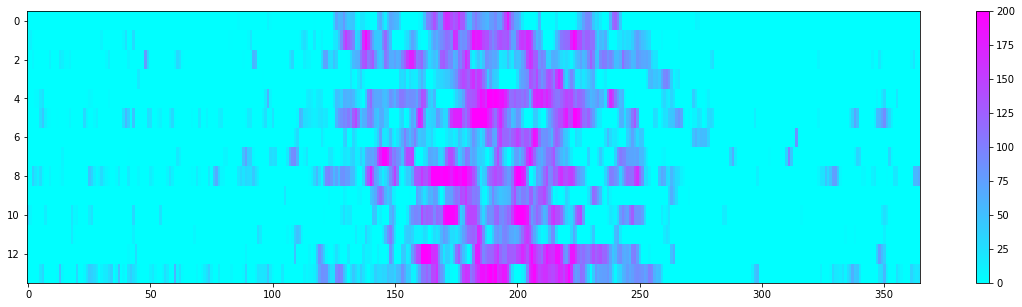

NameError: name 'N_per' is not defined

In [24]:
    
r_s_ = [0., 0.5, 1.]
OB_  = [1., 1.5, 2.]

for i in range(len(r_s_)):
    for j in range(len(OB_)):
        r_s = r_s_[i]
        r_w = 1 - r_s
        OB  = OB_[j]
        print(r_s, r_w, OB)
        
        a_hat_s, a_hat_w, beta_s_, beta_w_ = _avg_system_scale(S_cf_, W_cf_, s_Cap_, w_Cap_, L, r_s, OB)
        print(a_hat_s, a_hat_w)

        N_per_ = _resiliance(S_cf_, W_cf_, S_Cap_, W_Cap_, l_, a_hat_s, a_hat_w)
      
        plt.figure(figsize = (20, 5))
        plt.imshow(N_per_.T, aspect = 'auto', interpolation = 'none', vmin = 0, vmax = 200, cmap = 'cool')
        plt.colorbar()
        plt.ylim()
        plt.show()

        N_per_[N_per > 100] = 100

        plt.figure(figsize = (20, 5))
        plt.imshow(N_per_.T, aspect = 'auto', interpolation = 'none', vmin = 0, vmax = 100, cmap = 'inferno')
        plt.colorbar()
        plt.ylim()
        plt.show()
        

In [ ]:

l_ = np.sum(L_ , axis = 1)[:, np.newaxis] 
L  = np.sum(l_, axis = 0)
print(l_.shape)

In [343]:
def _testbed(y, r_solar, OB, S_cf_, W_cf_ , L , l_):

    S_cf_prime_ = S_cf_[:, :, y]            
    W_cf_prime_ = W_cf_[:, :, y]

    #Potential Solar energy capacity 
    S_Cap_ = s_Cap_[:, np.newaxis] 
    S_Cap_ = np.repeat(S_Cap_, S_cf_prime_.shape[1], axis = 1)

    E_solar_ = S_Cap_ * S_cf_prime_ 
    e_solar_ = np.sum(E_solar_, axis = 0)[:, np.newaxis]
    E_solar  = np.sum(e_solar_, axis = 0)

    #Potential Wind energy capacity 
    W_Cap_ = w_Cap_[:, np.newaxis] 
    W_Cap_ = np.repeat(W_Cap_, W_cf_prime_.shape[1], axis = 1) 

    E_wind_ = W_cf_prime_ * W_Cap_
    e_wind_ = np.sum(E_wind_, axis = 0)[:,np.newaxis] 
    E_wind  = np.sum(e_wind_,axis = 0)

    #Fraction of solar and wind energy to blance the demand.
    b_solar = L / E_solar  
    b_wind  = L / E_wind 
    r_wind  = 1. - r_solar

    a_solar = r_solar * b_solar * OB 
    a_wind  = r_wind  * b_wind  * OB

    #Hourly Energy Balance Between Load and Energy Generation
    e_solar_gen_ = a_solar * e_solar_
    e_wind_gen_  = a_wind * e_wind_

    met_        = np.sum(np.less(l_ , e_solar_gen_ + e_wind_gen_))
    print(np.less(l_ , e_solar_gen_ + e_wind_gen_).shape)
    unmet_      = np.sum(np.greater(l_ , e_solar_gen_ + e_wind_gen_))
    percent_met = met_/(unmet_ + met_)
    print(y, met_, unmet_, percent_met)
    return np.array([met_ , unmet_ , percent_met])[:, np.newaxis]

e_balance_ = []
for i in range(0,2):
    e_balance_.append(_testbed(i, .5, 1, S_cf_, W_cf_, L , l_))
E_balance_ = np.concatenate(e_balance_, axis = 1)
print(E_balance_.shape)
print(E_balance_)

(8760, 1)
0 3990 4770 0.4554794520547945
(8760, 1)
1 3949 4811 0.45079908675799085
(3, 2)
[[3.99000000e+03 3.94900000e+03]
 [4.77000000e+03 4.81100000e+03]
 [4.55479452e-01 4.50799087e-01]]


In [ ]:
def e_stats(data,  m):  
  #Quantile Statistics
    d_median = np.median(data, axis=m)

    d_quantiles_ =stats.mstats.mquantiles(data,[0.25, .50 ,0.75, 1.], axis=m)

    return d_median[0], d_quantiles_


In [ ]:
e_stats(e_solar_gen_,0)